<a href="https://colab.research.google.com/github/summitgao/colab_demo/blob/master/deepHSIprior_CVPR2019workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://hyperspectral.oss-cn-beijing.aliyuncs.com/denoising.mat

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import scipy.io
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from skimage.measure import compare_psnr

def add_module(self,module):
    self.add_module(str(len(self) + 1 ), module)

torch.nn.Module.add = add_module

def bn(num_features):
    return nn.BatchNorm2d(num_features)

def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()

def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':
        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False
        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0
  
    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)
    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)


def get_noisy_image(img_np, sigma):
    """Adds Gaussian noise to an image.
        img_np: image, np.array with values from 0 to 1
        sigma: std of the noise
    """
    img_noisy_np = np.clip(img_np + 
            np.random.normal(scale=sigma, size=img_np.shape), 0, 1).astype(np.float32)
    return img_noisy_np


def skip(
        num_input_channels=2, num_output_channels=3, 
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4], 
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True, 
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU', 
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')
    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down) 

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales
    
    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1 

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)
        
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))
            

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model


class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim
        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))
        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)
            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])
        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)



def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`) 
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler. 
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
        
    if method == '2D':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]] 
    elif method == '3D':
        shape = [1, 1, input_depth, spatial_size[0], spatial_size[1]]
    else:
        assert False

    net_input = torch.zeros(shape)
    
    fill_noise(net_input, noise_type)
    net_input *= var            
        
    return net_input
        

def fill_noise(x, noise_type):
    # Fills tensor `x` with noise of type `noise_type`.
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_() 
    else:
        assert False


def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
    return params


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False


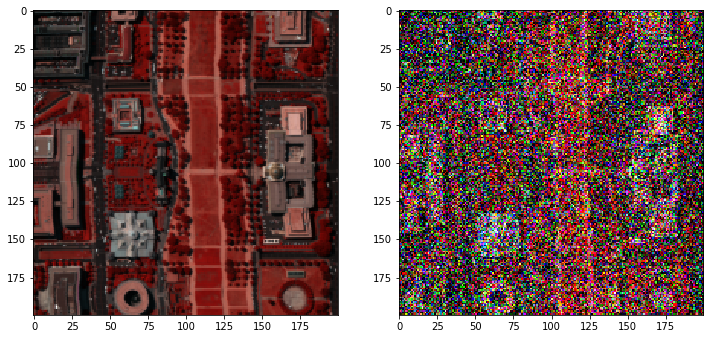

In [0]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

sigma = 100
sigma_ = sigma/255.0

file_name  = 'denoising.mat'
os.mkdir('results')
# ensure dimensions [0][1] are divisible by 32 (or 2^depth)!

mat = scipy.io.loadmat(file_name)
img_np = mat["image"]
img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(dtype)
img_noisy_np = get_noisy_image(img_np, sigma_)
img_noisy_var = torch.from_numpy(img_noisy_np).type(dtype)

plt.figure(figsize=(12, 6))
plt.subplot(121)   
plt.imshow(torch.stack((img_var[56,:,:],img_var[26,:,:],img_var[16,:,:]),2).cpu())   
plt.subplot(122)
plt.imshow(torch.stack((img_noisy_var[56,:,:],img_noisy_var[26,:,:],img_noisy_var[16,:,:]),2).cpu())

In [0]:
method = '2D'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 0.03 # 0 0.01 0.05 0.08
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
exp_weight=0.99

show_every = 200
save_every = 200

num_iter = 1801
input_depth = img_np.shape[0]  

net = skip(input_depth, img_np.shape[0],  
       num_channels_down = [128]*5,
       num_channels_up =   [128]*5,
       num_channels_skip =    [4]*5,  
       filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
       upsample_mode='bilinear', # downsample_mode='avg',
       need1x1_up=False,
       need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    
net_input = get_noise(input_depth, method, (img_np.shape[1], img_np.shape[2])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_var = img_noisy_var[None, :].cuda()

Number of params: 2342047


In [0]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure(): 
    global i, out_avg, psrn_noisy_last, last_net, net_input
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_var)
    total_loss.backward()
    
    out_np = out.detach().cpu().squeeze().numpy()
    out_avg_np = out_avg.detach().cpu().squeeze().numpy()

    psrn_noisy = compare_psnr(img_noisy_np.astype(np.float32), np.clip(out_np, 0, 1))  
    psrn_gt    = compare_psnr(img_np.astype(np.float32), np.clip(out_np, 0, 1)) 
    psrn_gt_sm = compare_psnr(img_np.astype(np.float32), np.clip(out_avg_np, 0, 1)) 
      
    print ('Iteration %05d    Loss %f  PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_gt, psrn_gt_sm), '\r', end='')
    if i % show_every == 0:
        out_np = np.clip(out_np, 0, 1)
        out_avg_np = np.clip(out_avg_np, 0, 1)    
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,15))
        ax1.imshow(np.stack((out_np[56,:,:],out_np[26,:,:],out_np[16,:,:]),2))
        ax2.imshow(np.stack((out_avg_np[56,:,:],out_avg_np[26,:,:],out_avg_np[16,:,:]),2))
        plt.show()
    
    if  i % save_every == 0:
        scipy.io.savemat("results/result_denoising_2D_it%05d.mat" % (i), {'pred':out_np.transpose(1,2,0),
                                                                              'pred_avg':out_avg_np.transpose(1,2,0)})
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.detach().copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1
    return total_loss


p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)